In [3]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pa

In [7]:
import networkx as nx
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.__version__

'1.3.0'

# **Area: San Antonio Downtown, Texas, USA**



Calculate basic street network measures (topological and geometric)

In [8]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
#stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats = ox.basic_stats(ox.graph_from_address('San Antonio Downtown, Texas, USA', dist=2000, simplify=True, network_type='drive'))
stats["circuity_avg"]

1.0186053378718274

In [11]:
# get the street network for a place, and its area in square meters
place = "San Antonio Downtown, Texas, USA"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_address('San Antonio Downtown, Texas, USA', dist=2000, simplify=True, network_type='drive')

In [12]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                            1307
m                                                                            3596
k_avg                                                                    5.502678
edge_length_total                                                      412576.542
edge_length_avg                                                        114.732075
streets_per_node_avg                                                     3.288447
streets_per_node_counts         {0: 0, 1: 74, 2: 10, 3: 703, 4: 506, 5: 13, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.056618209640397855, 2: 0.0076511...
intersection_count                                                           1233
street_length_total                                                    244884.046
street_segment_count                                                         2077
street_length_avg                                                      117.902766
circuity_avg    

In [13]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,1.307000e+03
m,3.596000e+03
k_avg,5.503000e+00
edge_length_total,4.125765e+05
edge_length_avg,1.147320e+02
streets_per_node_avg,3.288000e+00
intersection_count,1.233000e+03
street_length_total,2.448840e+05
street_segment_count,2.077000e+03
street_length_avg,1.179030e+02


Inspect betweenness centrality


In [14]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(149683922, 0.1396988846056808)

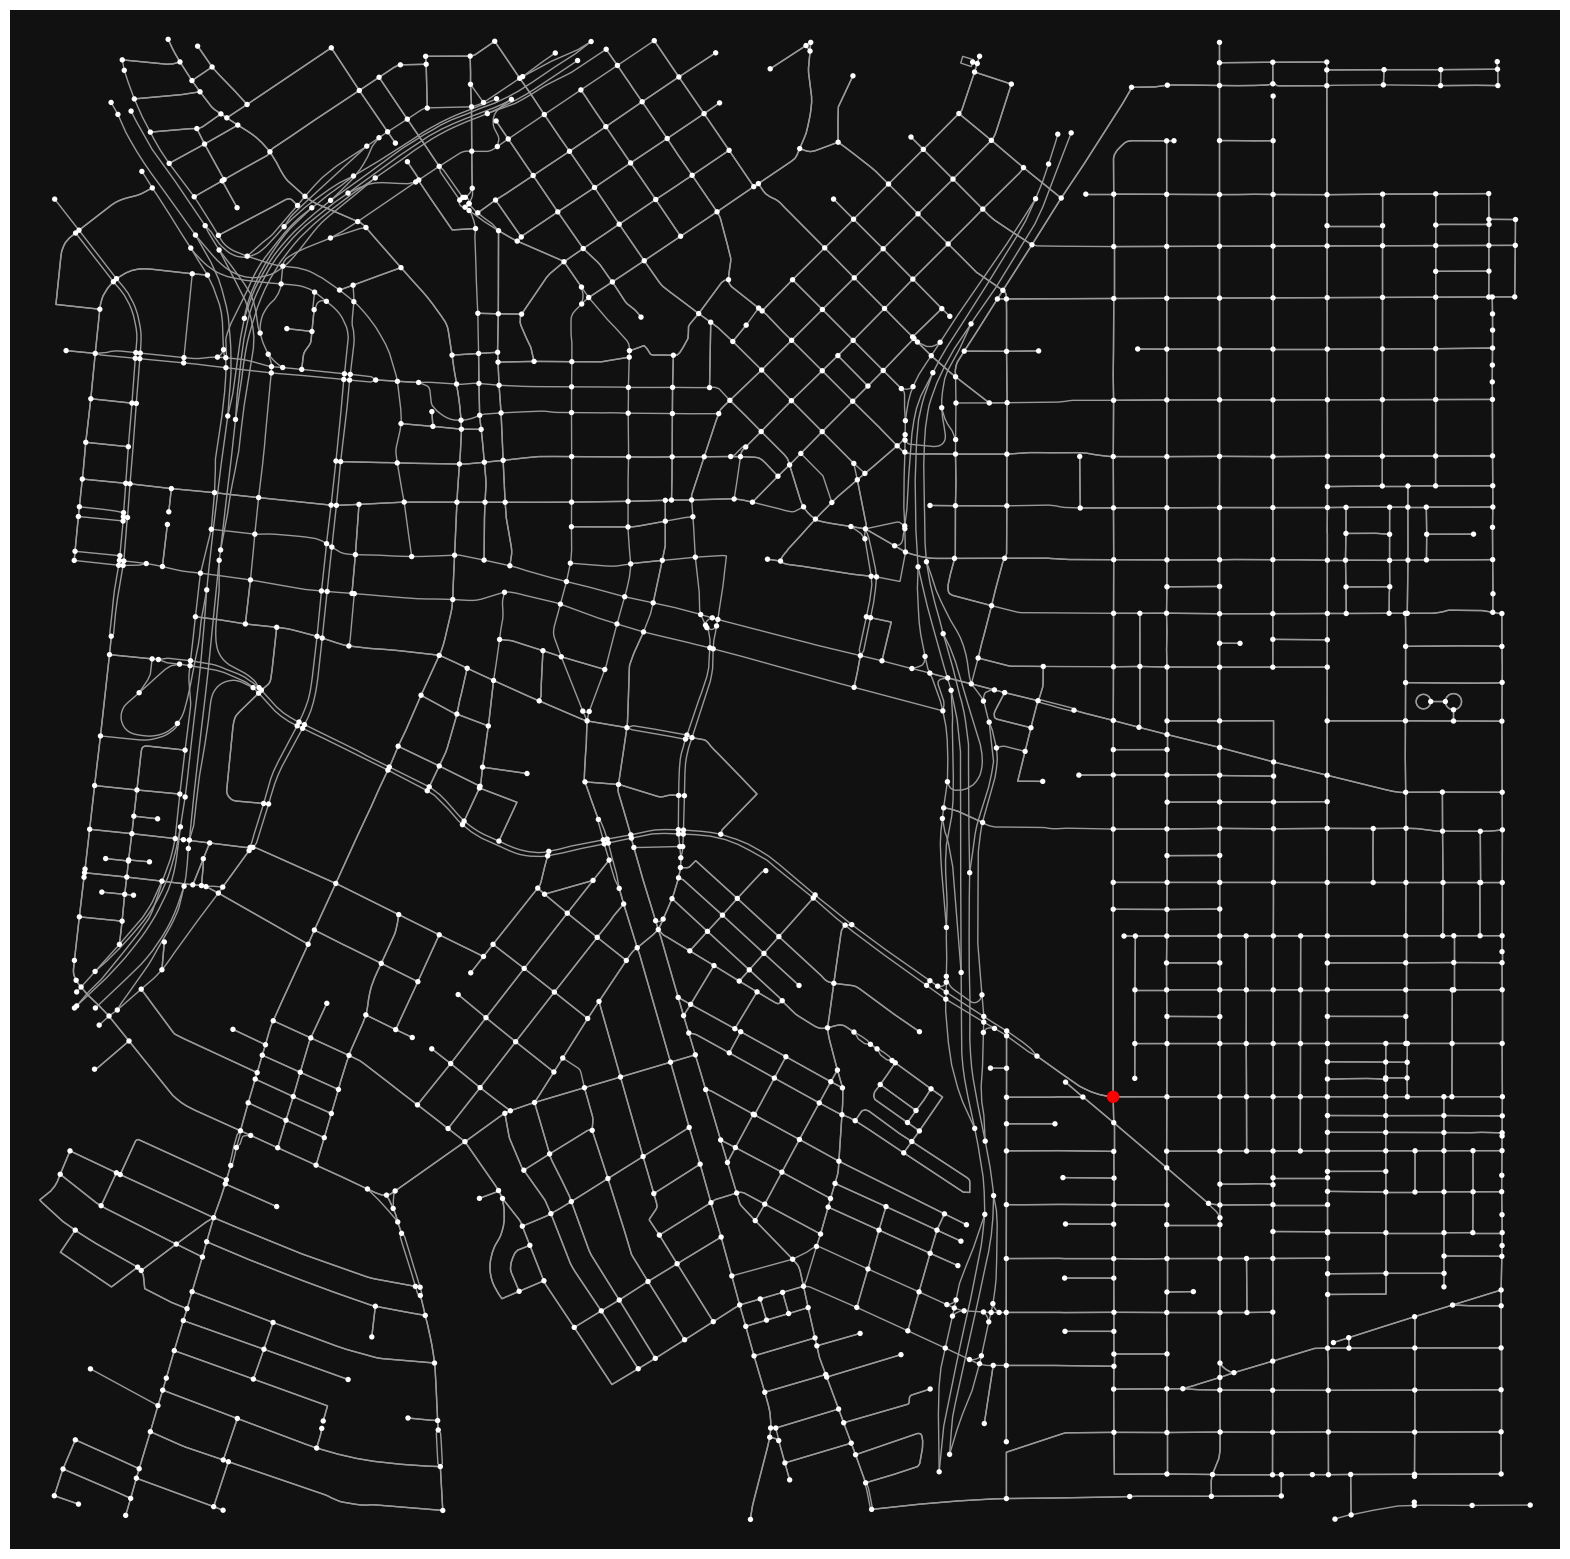

In [15]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G,figsize=(20,20), node_size=ns, node_color=nc, node_zorder=2)

all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:



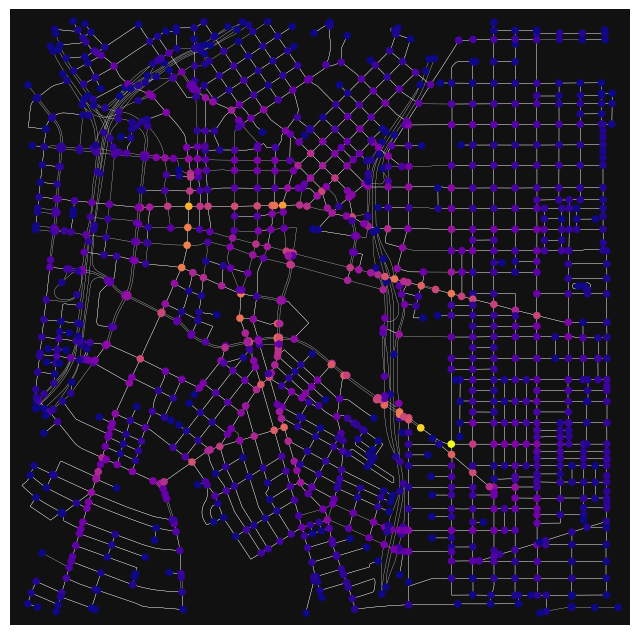

In [16]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

# **Area: UTSA main campus**

In [17]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
#stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats = ox.basic_stats(ox.graph.graph_from_bbox(29.5904, 29.5717, -98.6068, -98.6325, network_type='all', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None))
stats["circuity_avg"]

1.0835634470180513

In [18]:
# get the street network for a place, and its area in square meters
place = "1 UTSA Circle, San Antonio, TX 78249"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_address(place, dist=2000, simplify=True, network_type='drive')

In [19]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             488
m                                                                            1042
k_avg                                                                    4.270492
edge_length_total                                                      160658.175
edge_length_avg                                                         154.18251
streets_per_node_avg                                                     2.885246
streets_per_node_counts                 {0: 0, 1: 72, 2: 10, 3: 315, 4: 84, 5: 7}
streets_per_node_proportions    {0: 0.0, 1: 0.14754098360655737, 2: 0.02049180...
intersection_count                                                            416
street_length_total                                                    101949.743
street_segment_count                                                          681
street_length_avg                                                      149.705937
circuity_avg    

In [20]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,488.000
m,1042.000
k_avg,4.270
edge_length_total,160658.175
edge_length_avg,154.183
streets_per_node_avg,2.885
intersection_count,416.000
street_length_total,101949.743
street_segment_count,681.000
street_length_avg,149.706


Inspect betweenness centrality


In [21]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(149664530, 0.27567368874692627)

 The node with the highest betweenness centrality has --- of all shortest paths running through it.
all shortest paths run through the node highlighted in red


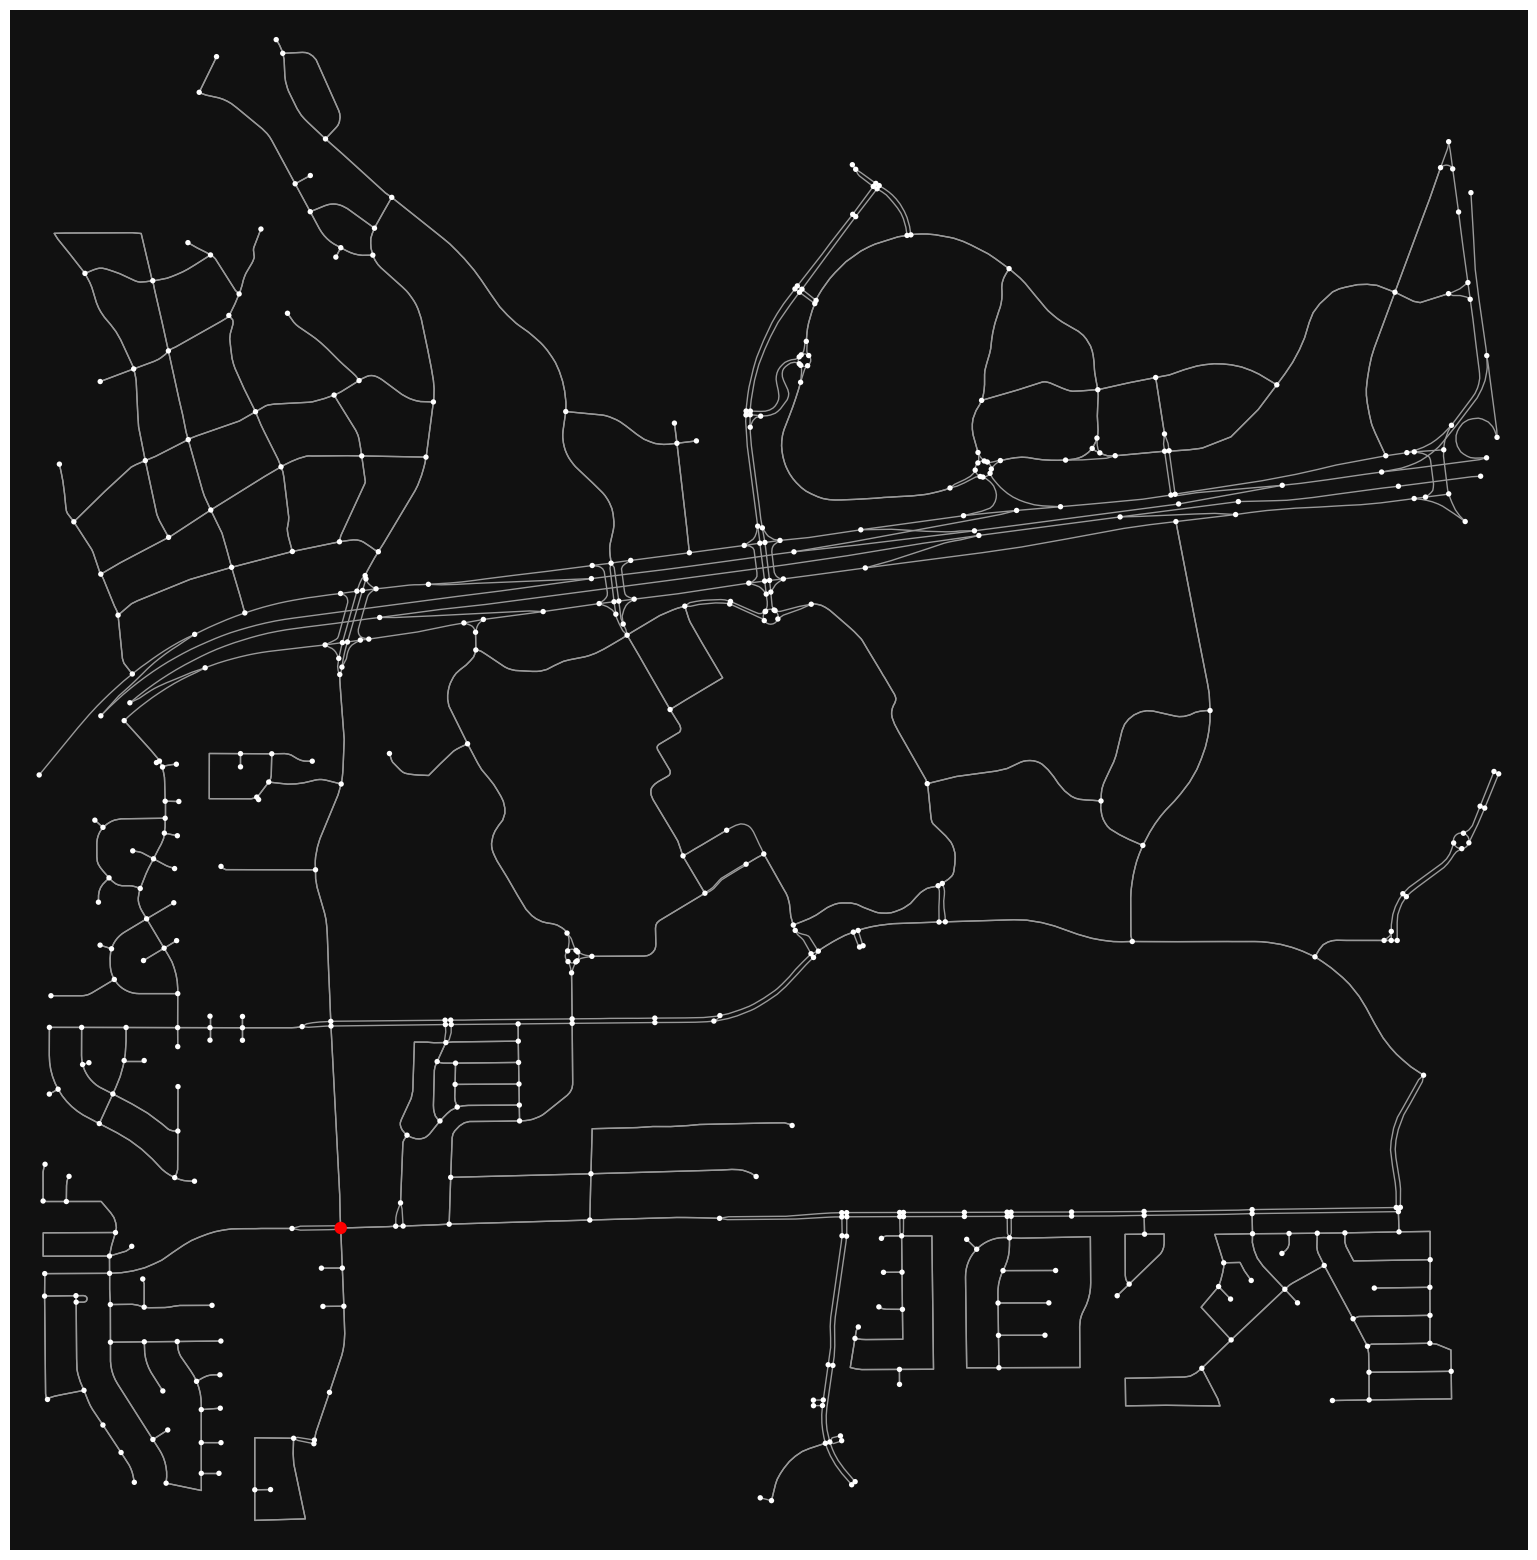

In [22]:
print(" The node with the highest betweenness centrality has --- of all shortest paths running through it.")
print("all shortest paths run through the node highlighted in red")
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G,figsize=(20,20), node_size=ns, node_color=nc, node_zorder=2)


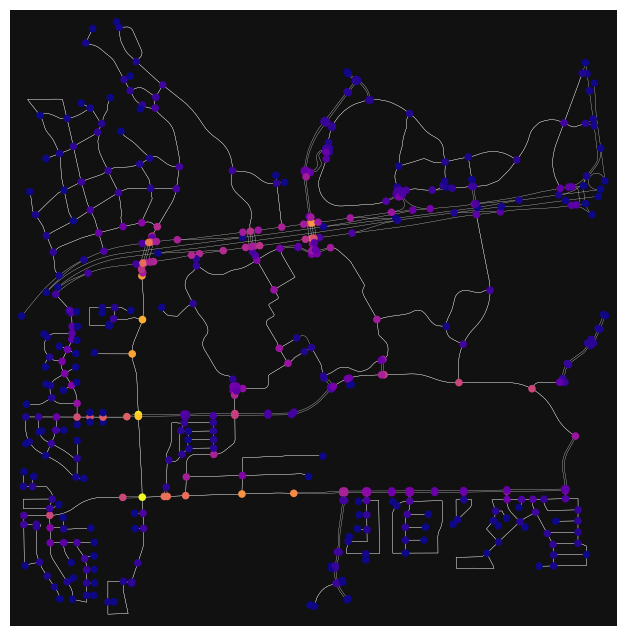

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.


In [23]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)
print("Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.")

# **Area: Bexar County, San Antonio**

In [24]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
#stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats = ox.basic_stats(ox.graph.graph_from_bbox(29.8740, 29.1120, -98.1079, -98.8323, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None))
stats["circuity_avg"]

1.0708220649352302

In [25]:
# get the street network for a place, and its area in square meters
place = "Bexar County, TX"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_address(place, dist=2000, simplify=True, network_type='drive')

In [26]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                            1347
m                                                                            3877
k_avg                                                                    5.756496
edge_length_total                                                      446173.731
edge_length_avg                                                        115.082211
streets_per_node_avg                                                     3.326652
streets_per_node_counts               {0: 0, 1: 100, 2: 6, 3: 606, 4: 624, 5: 11}
streets_per_node_proportions    {0: 0.0, 1: 0.07423904974016332, 2: 0.00445434...
intersection_count                                                           1247
street_length_total                                                    257416.381
street_segment_count                                                         2171
street_length_avg                                                       118.57042
circuity_avg    

In [27]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,1347.000
m,3877.000
k_avg,5.756
edge_length_total,446173.731
edge_length_avg,115.082
streets_per_node_avg,3.327
intersection_count,1247.000
street_length_total,257416.381
street_segment_count,2171.000
street_length_avg,118.570


In [28]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(1546967044, 0.14551445284665565)

 The node with the highest betweenness centrality has --- of all shortest paths running through it.
all shortest paths run through the node highlighted in red


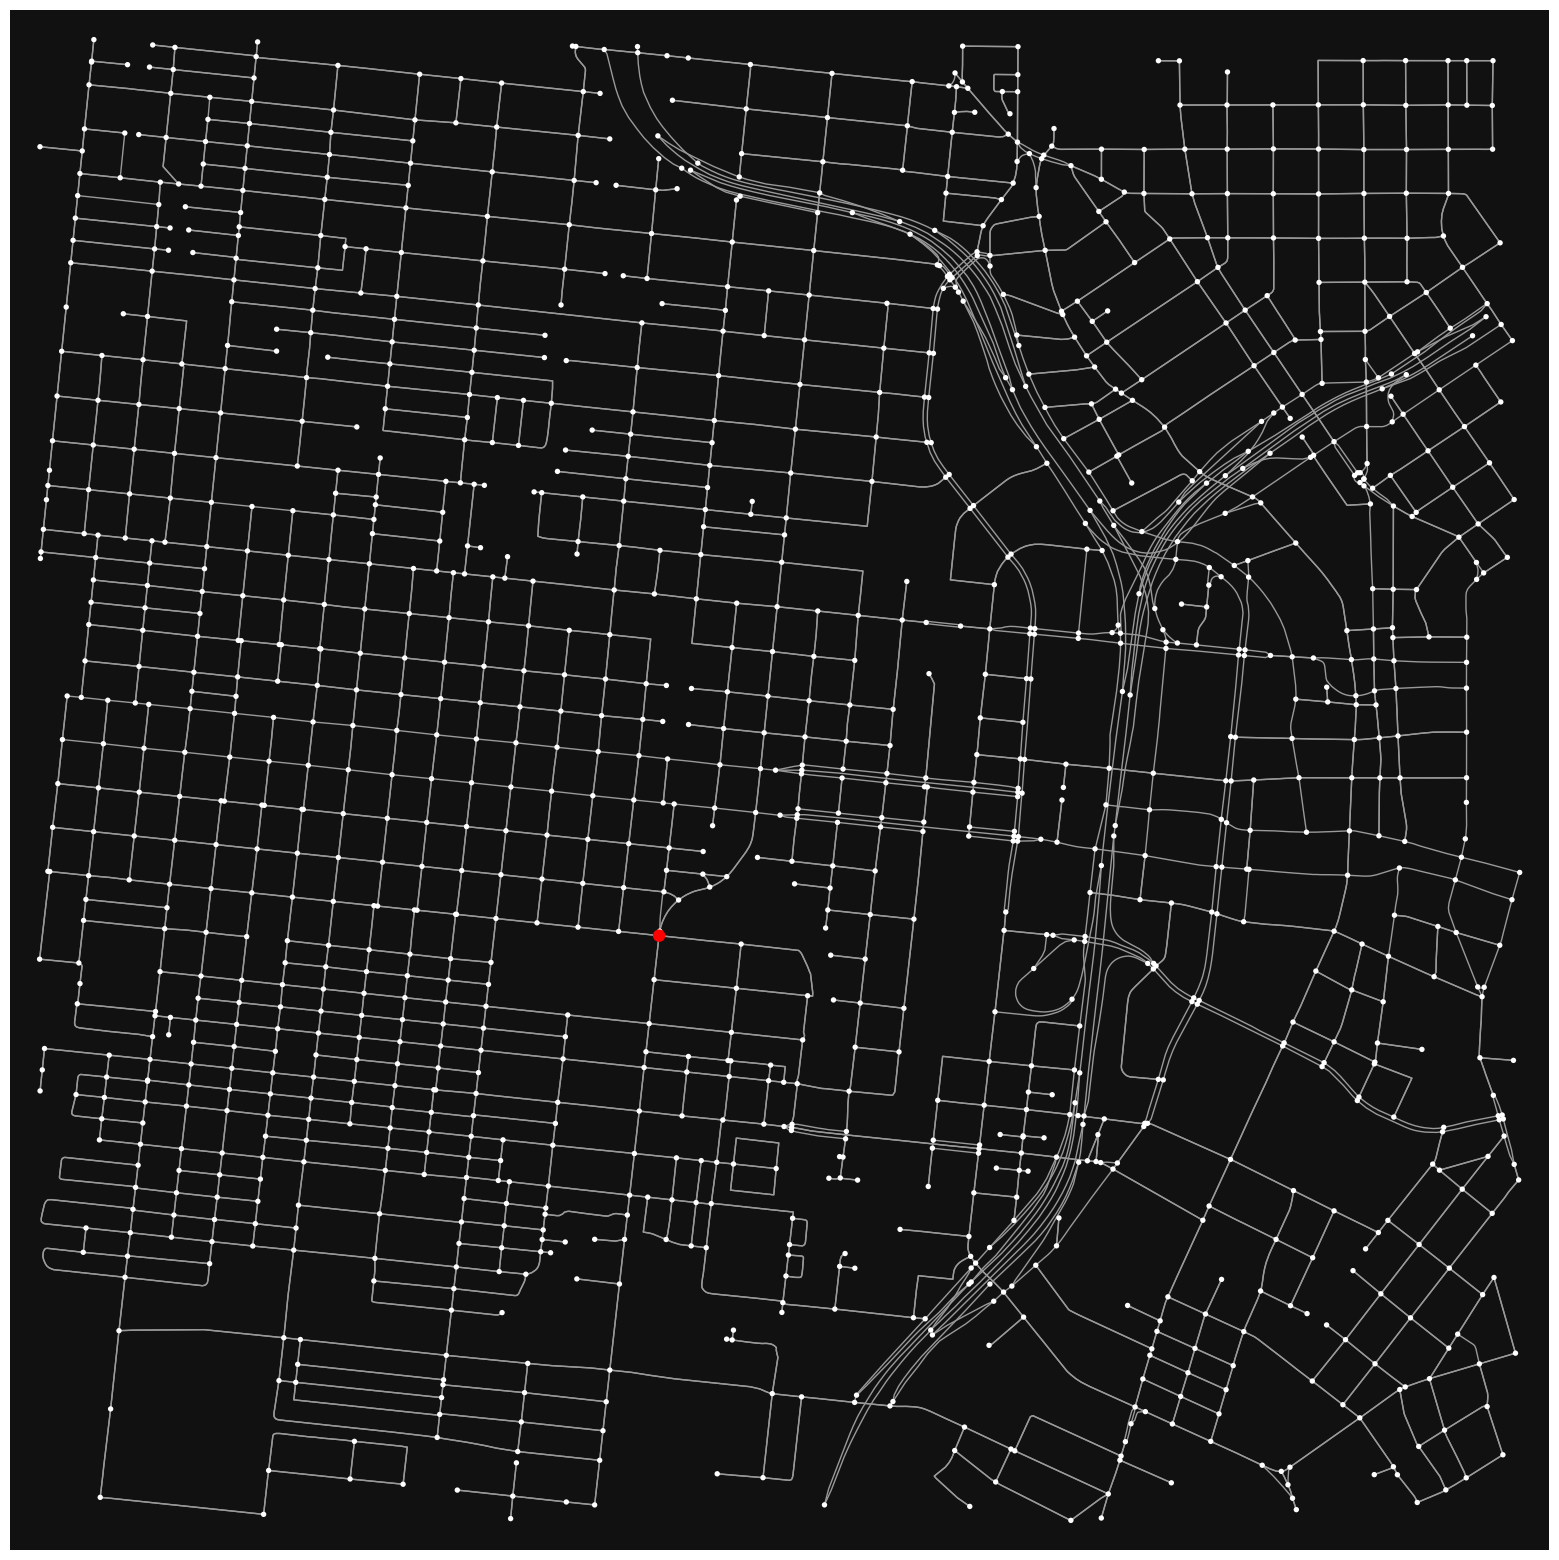

In [29]:
print(" The node with the highest betweenness centrality has --- of all shortest paths running through it.")
print("all shortest paths run through the node highlighted in red")
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G,figsize=(20,20), node_size=ns, node_color=nc, node_zorder=2)

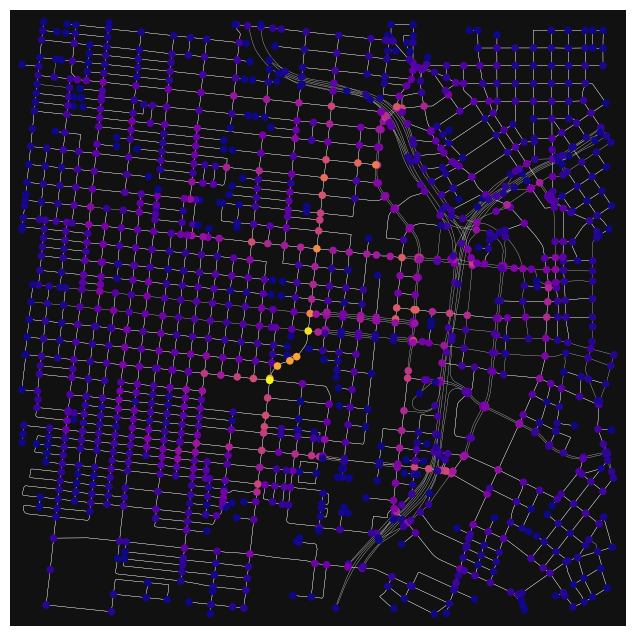

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.


In [30]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)
print("Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.")